# 회귀 모델 학습 (y: 사용전력량)
## 실험7) 직전 'C-inj' 사용 방식에서 다양한 모델, 전처리, 변수 적용 등으로 최대 성능 확보
## 실험7-5) 최고 성능 LR 모델

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import requests
import os
import random
import warnings
# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import shap

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [145]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [146]:
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

In [147]:
def set_all_seeds(seed):
    """
    Sets the random seeds for Python, NumPy, and optionally TensorFlow and PyTorch
    to ensure reproducibility.
    """
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed)
    
    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed)

In [148]:
SEED_VALUE = 42
set_all_seeds(SEED_VALUE)

In [149]:
def scatter_plot_r2(data, col_name_1, col_name_2):
    # --- Data Preparation ---
    # Ensure the analysis runs without errors by removing any rows with missing data (NaN)
    # in the relevant columns.
    valid_data = data[[col_name_1, col_name_2]].dropna()
    x = valid_data[col_name_1]
    y = valid_data[col_name_2]

    # --- Linear Regression Analysis ---
    # Perform the linear regression to find the best-fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Calculate R-squared, which measures how well the x-variable predicts the y-variable
    r_squared = r_value**2

    # --- Visualization ---
    # Create the figure and scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, s=5, alpha=0.6, label='Actual Data')

    # Plot the regression line using the calculated slope and intercept
    line = slope * x + intercept
    plt.plot(x, line, color='red', label='Regression Line')

    # --- Final Touches ---
    # Add labels, a title, and a grid for better readability
    plt.xlabel(col_name_1)
    plt.ylabel(col_name_2)
    plt.title(f'\'{col_name_2}\' vs. \'{col_name_1}\'')
    plt.grid(True)

    # Display the R-squared value in a text box on the plot
    # The '$' signs render the text in a mathematical font
    plt.text(0.05, 0.95, f'$R^2 = {r_squared:.4f}$',
            transform=plt.gca().transAxes,
            fontsize=12,
            verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

    # Show the legend to identify the data points and the line
    plt.legend()

    # Display the final plot
    plt.show()

def scatter_plot_metric(y_true, y_pred, metrics):
    metric_values = {
        'mae': None,
        'rmse': None,
        'r2': None,
        'mape': None,
        }
    if 'mae' in metrics:
        metric_values['mae'] = mean_absolute_error(y_true, y_pred)
    if 'rmse' in metrics:
        metric_values['rmse'] = root_mean_squared_error(y_true, y_pred)
    if 'r2' in metrics:
        metric_values['r2'] = r2_score(y_true, y_pred)
    if 'mape' in metrics:
        metric_values['mape'] = mean_absolute_percentage_error(y_true, y_pred)

    # --- New code for plotting ---
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)

    # Add a line for perfect predictions (y=x)
    lims = [
        np.min([plt.gca().get_xlim(), plt.gca().get_ylim()]),
        np.max([plt.gca().get_xlim(), plt.gca().get_ylim()]),
    ]
    plt.plot(lims, lims, 'r--', alpha=0.75, label='Perfect Fit')

    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"True vs. Predicted Values")
    plt.grid(True)

    # --- Annotation Logic ---
    # 1. Create a list of formatted strings for metrics that were calculated
    text_parts = []
    if metric_values['mae'] is not None:
        text_parts.append(f"MAE: {metric_values['mae']:.2f}")
    if metric_values['rmse'] is not None:
        text_parts.append(f"RMSE: {metric_values['rmse']:.2f}")
    if metric_values['r2'] is not None:
        text_parts.append(f"R²: {metric_values['r2']:.2f}") # Use a proper R-squared symbol
    if metric_values['mape'] is not None:
        text_parts.append(f"MAPE: {metric_values['mape']:.2f}%")

    # 2. If the list is not empty, join the parts into a single multi-line string
    if text_parts:
        annotation_text = "\n".join(text_parts)
        # 3. Plot the string on the graph
        plt.text(0.05, 0.95, annotation_text,
                 transform=plt.gca().transAxes,
                 fontsize=12,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

In [150]:
merged_df = pd.read_csv('C:/Users/User/kyushu_with_weather_notequals1_with_counter.csv', low_memory=False)
merged_df.shape

(2489, 390)

In [151]:
# 온도값이 NaN인 인스턴스 제거
merged_df.dropna(subset=['temp'], inplace=True)
merged_df.shape

(2484, 390)

In [ ]:
# 학습에 필요한 변수 리스트 선언
# Time index
time_col = [
    'time',
]

# 고철 종류별 장입량
scraps_col = [
    '스크랩_S01_친',
    '스크랩_S01_자',
    # '스크랩_S01_손', # for GPR
    'A부스러기　친',
    'A부스러기 자',
    'A부스러기 손',
    # '친단　친', # for GPR
    '친단　자',
    '친단　손',
    '와셔 친',
    # '와셔 자', # for GPR
    # '와셔 손', # for GPR
    'B부스러기　친',
    'B부스러기 자',
    'B부스러기 손',
    '선다라이 친',
    # '선다라이 자', # for GPR
    # '선다라이 손', # for GPR
    # '류선 친', # for GPR
    '류선 자',
    # '류선 손', # for GPR
    '시타마와리(자동차 부품으로 예상됨)　친',
    # '시타마와리(자동차 부품으로 예상됨)　자', # for GPR
    # '시타마와리(자동차 부품으로 예상됨)　손', # for GPR
    '엔진 친',
    # '엔진 자',
    # '엔진 손',
    '슈레더 친',
    '슈레더 자',
    '슈레더 손',
    'C프레스 친',
    'C프레스 자',
    # 'C프레스 손', # for GPR
    # '다라이가루 친', # for GPR
    '다라이가루 자',
    '다라이가루 손',
    '강류 친',
    # '강류 자', # for GPR
    # '강류 손', # for GPR
    '타이어 친',
    # '타이어　자', # for GPR
    # '타이어　손', # for GPR
    '주물　친',
    # '주물　자', # for GPR
    # '주물　손', # for GPR
    # '알루미더스트　친', # for GPR
    # '알루미더스트　자', # for GPR
    # '알루미더스트　손', # for GPR
    # 'AB프레스　친', # for GPR
    # 'AB프레스　자', # for GPR
    # 'AB프레스　손', # for GPR
    # 'Mn강　친', # for GPR
    # 'Mn강　자', # for GPR
    # 'Mn강　손', # for GPR
    # '캔버서　친', # for GPR
    # '캔버서　자', # for GPR
    # '캔버서　손', # for GPR
    # '페인트캔　친', # for GPR
    # '페인트캔　자', # for GPR
    # '페인트캔　손', # for GPR
    'V프레스　친',
    # 'V프레스　자', # for GPR
    # 'V프레스　손', # for GPR
    # '캔프레스　친', # for GPR
    '캔프레스　자',
    # '캔프레스　손', # for GPR
    '빌렛부스러기　친',
    # '빌렛부스러기 자', # for GPR
    # '빌렛부스러기 손', # for GPR
    # 'SC（레들）바탕쇠　친', # for GPR
    'SC（레들）바탕쇠　자',
    # 'SC（레들）바탕쇠　손', # for GPR
    # 'EF바탕쇠　친', # for GPR
    'EF바탕쇠　자',
    # 'EF바탕쇠　손', # for GPR
    # 'CC바탕쇠　친', # for GPR
    # 'CC바탕쇠　자', # for GPR
    # 'CC바탕쇠　손', # for GPR
    '정비부스러기　친',
    # '정비부스러기　자', # for GPR
    # '정비부스러기　손', # for GPR
]

# 첨가제 종류별 장입량
additives_col = [
    # 'CaO',
    # 'CaO(ﾌﾚｺﾝ)',
    # 'FeSi75',
    # 'FeMn',
    # 'SiMn',
    # 'SiC',
    # 'CaSi',
    # 'FeSi70',
    'C-inj(佐山)',
    # '봉지포장카본ﾝ',
    # '무연탄',
    # '알루미늄 재(ﾌﾚ)',
    # '알루미늄 재(종이)',
    # '취부재',
    # '마그네시아',
    # '로상재',
    # '구C-inj',
    # 'FeNi',
    # 'FeMo',
    # 'FeCr',
    # 'FeV(50)',
    # 'SiMn0-20',
    # '재생카본',
    # '냉재',
    # 'SiMn1-3',
    # 'Fe-Mn1-3',
    # 'FeSi(P)',
    # '부자재_A28',
    # '부자재_A29',
    # '부자재_A30',
    ############
    '통전시간_합계',
]

extra_col = [
    '연회회수',
    '누적장입생산차이t'
    ###############
    # '란스O2_로 보수/수리',
    # '란스O2_주요장입',
    # '란스O2_추가1',
    # '란스O2_추가2',
    # '란스O2_산화',
    # '란스O2_환원',
    # '버너O2_로 보수/수리',
    # '버너O2_주요장입',
    # '버너O2_추가1',
    # '버너O2_추가2',
    # '버너O2_산화',
    # '버너O2_환원',
    # '버너오일_로 보수/수리',
    # '버너오일_주요장입',
    # '버너오일_추가1',
    # '버너오일_추가2',
    # '버너오일_산화',
    # '버너오일_환원',
    # 'PSAO2_로 보수/수리',
    # 'PSAO2_주요장입',
    # 'PSAO2_추가1',
    # 'PSAO2_추가2',
    # 'PSAO2_산화',
    # 'PSAO2_환원',
    # 'LO2_로 보수/수리',
    # 'LO2_주요장입',
    # 'LO2_추가1',
    # 'LO2_추가2',
    # 'LO2_산화',
    # 'LO2_환원',
]

# 큐슈제강 조업 날씨
weather_col = [
    'temp', # 기온 (섭씨)
    'rhum', # 상대습도 (%)
    # 'prcp',
    # 'pres',
]

# 기타 (for feature engineering)
etc_col = [
    '강종명',
]

# 출력 변수
target_col = [
    '사용전력량'
]

In [153]:
# 학습에 필요한 변수만을 추출
selected_df = merged_df[time_col + scraps_col + additives_col + extra_col + weather_col + etc_col + target_col]
selected_df.fillna(0, inplace=True)
selected_df['time'] = pd.to_datetime(selected_df['time'])

C:\Users\User\AppData\Local\Temp\ipykernel_24260\2953839804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df.fillna(0, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_24260\2953839804.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['time'] = pd.to_datetime(selected_df['time'])


In [154]:
# Feature pipeline
# 훈련 데이터의 강종별 'C-inj(佐山)' 평균과 표준편차를 저장함.
# 이후 for 문을 돌면서 현재 샘플의 강종명을 저장해두고,
# 강종명이 일치하고, 정합성을 만족하는 이전 시점 샘플 탐색.
# 탐색에 성공한 경우 해당 샘플의 'C-inj(佐山)'을 불러와서 현재 샘플 값으로 사용함.
# 탐색에 실패한 경우 저장된 훈련 데이터의 강종별 평균을 사용함.
# 평균값도 없으면 해당 인스턴스의 'C-inj(佐山)'은 NaN 값으로 채움.

# 정합성 만족 기준은 평균 +- n 표준편차 이내

def feature_pipeline(df, additives_col, etc_col, train_df_for_stats=None, time_col='time', n_std=3, drop_na=True):
    """
    Performs feature engineering on a given dataframe.
    - If train_df_for_stats is provided (inference mode), it uses stats from that dataframe.
    - If not (training mode), it calculates stats from the input df itself.

    The logic is as follows:
    1. Calculate mean and std for each steel grade from the stats source.
    2. For each row in the target df, find the value from the previous heat of the same grade.
    3. If the previous value is valid (within n_std of the grade's mean), use it.
    4. If not, use the grade's average as a fallback.
    5. Drop rows with remaining NaNs if drop_na is True.
    """
    # Create a copy to avoid modifying the original DataFrame
    df_processed = df.copy()

    # --- 1. Determine the source for statistics and calculate them ---
    if train_df_for_stats is not None:
        # Inference mode: Use the provided training data to calculate stats
        stats_source_df = train_df_for_stats
        print("Running in INFERENCE mode: Using stats from provided train_df.")
    else:
        # Training mode: Use the input dataframe itself to calculate stats
        stats_source_df = df_processed
        print("Running in TRAINING mode: Using stats from the input df itself.")
        
    # Calculate stats for the validity check (mean and std from the stats source)
    grade_stats = stats_source_df.groupby('강종명')[additives_col].agg(['mean', 'std'])

    # --- 2. Apply feature engineering to the target dataset ---
    # Sort the target dataframe by time to correctly identify the previous heat
    df_processed.sort_values(by=time_col, inplace=True)

    # Loop through each additive column
    for col in additives_col:
        # Get the value from the previous heat of the same grade
        prev_values = df_processed.groupby('강종명')[col].shift(1)

        # Get the corresponding stats for each row's grade, using the stats from the source
        mean_values = df_processed['강종명'].map(grade_stats[col]['mean'])
        std_values = df_processed['강종명'].map(grade_stats[col]['std'])

        # --- Apply the validation logic ---
        # Default to using the grade's average value
        new_col = mean_values.copy()

        # Calculate validity bounds using the source stats
        lower_bound = mean_values - n_std * std_values
        upper_bound = mean_values + n_std * std_values

        # Create a mask for rows where the previous value is valid
        is_valid_prev = (prev_values.notna()) & \
                        (prev_values >= lower_bound) & \
                        (prev_values <= upper_bound)

        # --- Print count of times where mean is used ---
        mean_used_mask = ~is_valid_prev
        count_mean_used = mean_used_mask.sum()
        if count_mean_used > 0:
            print(f"  - Using mean for '{col}' {count_mean_used} times.")

        # Where the mask is True, update the new column with the valid previous value
        new_col.loc[is_valid_prev] = prev_values[is_valid_prev]
        
        # Replace the original column with the newly calculated values
        df_processed[col] = new_col

    # 3. If drop_na is True, remove rows that couldn't be filled
    if drop_na:
        initial_rows = len(df_processed)
        df_processed.dropna(subset=additives_col, inplace=True)
        print(f'  - NaN instances dropped: {initial_rows - len(df_processed)}')

    # 4. Drop etc_col as specified
    df_final = df_processed.drop(columns=etc_col)
    
    return df_final, df_processed

In [155]:
# 훈련/테스트 분할.
# 훈련 데이터는 2024년 1월~9월, 테스트 데이터는 2024년 10월~12월 데이터로 설정함.
test_start_date = '2024-10-01'

# 3. Filter the DataFrame to create the training set
train_df = selected_df[selected_df['time'] < test_start_date]

# 4. Filter the DataFrame to create the test set
test_df = selected_df[selected_df['time'] >= test_start_date]

In [156]:
# train_df.to_csv('temp_train_df_before.csv', encoding='utf-8-sig')
# test_df.to_csv('temp_test_df_before.csv', encoding='utf-8-sig')

# --- 시나리오 1: 모델 학습 (Training) ---
# train_data만 함수에 전달합니다.
# 이 경우, 함수는 train_data 자체의 통계치(평균, 표준편차)를 계산하여 피처 엔지니어링을 수행합니다.
print("--- PROCESSING TRAINING DATA ---")
processed_train_df, processed_train_df_with_etc_col = feature_pipeline(
    df=train_df,
    additives_col=additives_col,
    etc_col=etc_col,
    )

# --- 시나리오 2: 모델 추론 (Inference) ---
# test_data를 처리하기 위해 함수를 호출하지만, 통계치 계산의 기준이 될 train_data를 함께 전달합니다.
print("--- PROCESSING TEST DATA ---")
processed_test_df, processed_test_df_with_etc_col = feature_pipeline(
    df=test_df, # df: 모델의 학습 데이터 이후 시점의 데이터 (즉, 학습 데이터 마지막 시점 ~ 현재 추론 시점까지의 데이터)
    additives_col=additives_col,
    etc_col=etc_col,
    train_df_for_stats=train_df, # 모델의 학습 데이터
    )

# processed_train_df_with_etc_col.to_csv('temp_train_df_after.csv', encoding='utf-8-sig')
# processed_test_df_with_etc_col.to_csv('temp_test_df_after.csv', encoding='utf-8-sig')

--- PROCESSING TRAINING DATA ---
Running in TRAINING mode: Using stats from the input df itself.
  - Using mean for 'C-inj(佐山)' 10 times.
  - Using mean for '통전시간_합계' 15 times.
  - NaN instances dropped: 0
--- PROCESSING TEST DATA ---
Running in INFERENCE mode: Using stats from provided train_df.
  - Using mean for 'C-inj(佐山)' 7 times.
  - Using mean for '통전시간_합계' 6 times.
  - NaN instances dropped: 0


In [157]:
# 데이터셋에서 time, target 컬럼 제거
X_train_df = processed_train_df.drop(columns=time_col + target_col)
X_test_df = processed_test_df.drop(columns=time_col + target_col)

y_train = processed_train_df[target_col]
y_test = processed_test_df[target_col]

In [158]:
# # 스케일링 미수행.
# # scaler = MinMaxScaler()
# # scaler.fit(X_train_df)
# X_train = pd.DataFrame(np.array(X_train_df), 
#                        columns=X_train_df.columns, 
#                        index=X_train_df.index)
# X_test = pd.DataFrame(np.array(X_test_df), 
#                       columns=X_test_df.columns, 
#                       index=X_test_df.index)
# X_train.shape, X_test.shape

In [159]:
# 스케일링 수행.
scaler = StandardScaler()
scaler.fit(X_train_df)
X_train = pd.DataFrame(scaler.transform(X_train_df), 
                       columns=X_train_df.columns, 
                       index=X_train_df.index)
X_test = pd.DataFrame(scaler.transform(X_test_df), 
                      columns=X_test_df.columns, 
                      index=X_test_df.index)
X_train.shape, X_test.shape

((1802, 37), (682, 37))

In [160]:
from sklearn.metrics import mean_absolute_error

In [161]:
# Import necessary regressor classes from scikit-learn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process.kernels import RBF
from xgboost import XGBRegressor

# --------------------------------------------------------------------------
# 1. K Neighbors Regressor
# --------------------------------------------------------------------------
knn_regressor = KNeighborsRegressor(
)

# --------------------------------------------------------------------------
# 2. MLP Regressor (Multi-layer Perceptron)
# --------------------------------------------------------------------------
mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(45,),
    activation='relu',
    solver='adam',
    alpha=0.00001,
    batch_size='auto',
    learning_rate='constant',
    # max_iter=279,
    # tol=0.0001,
    # momentum=0.9,
    # epsilon=1e-08
)

# --------------------------------------------------------------------------
# 3. Random Forest Regressor
# --------------------------------------------------------------------------
# Note: For scikit-learn >= 1.0, criterion 'mse' is an alias for 'squared_error'.
random_forest_regressor = RandomForestRegressor(
)

# --------------------------------------------------------------------------
# 4. Linear Regression
# --------------------------------------------------------------------------
# linear_regressor = LinearRegression(
linear_regressor = LinearRegression(
    fit_intercept=True
)

# --------------------------------------------------------------------------
# 5. Support Vector Regression (SVR)
# --------------------------------------------------------------------------
svr_regressor = SVR(
)

# --------------------------------------------------------------------------
# 6. Decision Tree Regressor
# --------------------------------------------------------------------------
decision_tree_regressor = DecisionTreeRegressor(
    max_depth=5,
)

# --------------------------------------------------------------------------
# 7. Gradient Boosting Regressor
# --------------------------------------------------------------------------
# Note: loss 'lad' is an alias for 'least_absolute_deviation'.
gradient_boosting_regressor = GradientBoostingRegressor(
)

# --------------------------------------------------------------------------
# 8. Gradient Boosting Regressor
# --------------------------------------------------------------------------
xgboost_regressor = XGBRegressor(
    max_depth=3,
    min_chile_weight=5,
    eta=0.03,
    gamma=3,
    subsample=0.6,
    colsample_bytree=0.65,
    reg_alpha=0.0004,
    reg_lambda=0.07,
    n_estimators=1000,
)

# --------------------------------------------------------------------------
# 9. Lasso Regression
# --------------------------------------------------------------------------
lasso_regressor = Lasso(
    fit_intercept=True
)

# --------------------------------------------------------------------------
# 10. Ridge Regression
# --------------------------------------------------------------------------
ridge_regressor = Ridge(
    fit_intercept=True
)

# You can store all models in a dictionary for easy access and iteration
models = {
    'KNN': knn_regressor,
    'MLP': mlp_regressor,
    'RF': random_forest_regressor,
    'LR': linear_regressor,
    'SVR': svr_regressor,
    'DT': decision_tree_regressor,
    'GB': gradient_boosting_regressor,
    'XGB': xgboost_regressor,
    'Lasso': lasso_regressor,
    'Ridge': ridge_regressor,
}

In [162]:
predicts = {
    'KNN': [None, None],
    'MLP': [None, None],
    'RF': [None, None],
    'LR': [None, None],
    'SVR': [None, None],
    'DT': [None, None],
    'GB': [None, None],
    'XGB': [None, None],
    'Lasso': [None, None],
    'Ridge': [None, None],
    'GPR': [None, None],
}

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1770: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KNN | train MAE: 296.01 RMSE: 408.11 R2: 0.55 | test MAE: 434.73 RMSE: 556.64 R2: -0.03


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MLP | train MAE: 17329.68 RMSE: 17341.85 R2: -810.57 | test MAE: 17138.23 RMSE: 17147.58 R2: -978.92
RF | train MAE: 135.74 RMSE: 183.89 R2: 0.91 | test MAE: 378.30 RMSE: 474.76 R2: 0.25
LR | train MAE: 371.09 RMSE: 488.43 R2: 0.36 | test MAE: 388.82 RMSE: 489.75 R2: 0.20


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR | train MAE: 448.18 RMSE: 600.81 R2: 0.03 | test MAE: 441.76 RMSE: 593.51 R2: -0.17
DT | train MAE: 373.51 RMSE: 486.29 R2: 0.36 | test MAE: 413.86 RMSE: 553.40 R2: -0.02


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GB | train MAE: 303.51 RMSE: 395.77 R2: 0.58 | test MAE: 385.25 RMSE: 477.24 R2: 0.24


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:26:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "min_chile_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB | train MAE: 225.59 RMSE: 294.32 R2: 0.77 | test MAE: 398.20 RMSE: 491.73 R2: 0.19
Lasso | train MAE: 371.11 RMSE: 488.61 R2: 0.36 | test MAE: 389.80 RMSE: 487.26 R2: 0.21
Ridge | train MAE: 371.08 RMSE: 488.43 R2: 0.36 | test MAE: 388.81 RMSE: 489.14 R2: 0.20


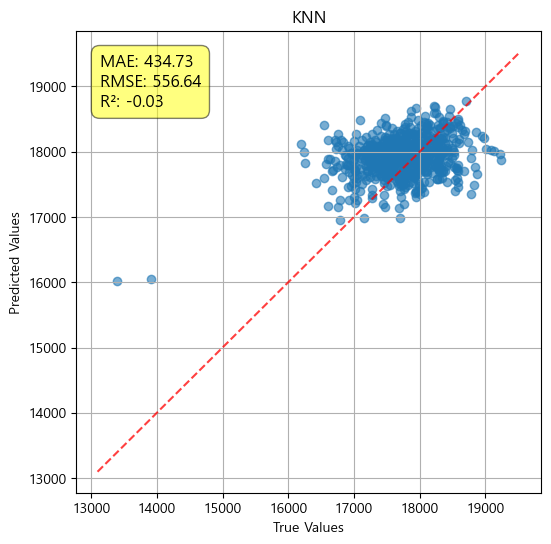

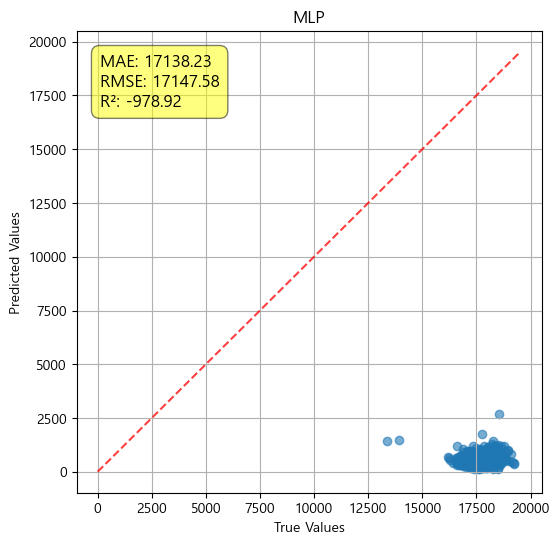

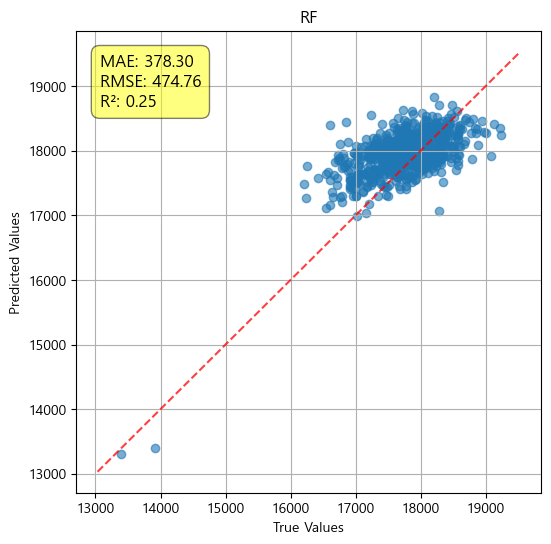

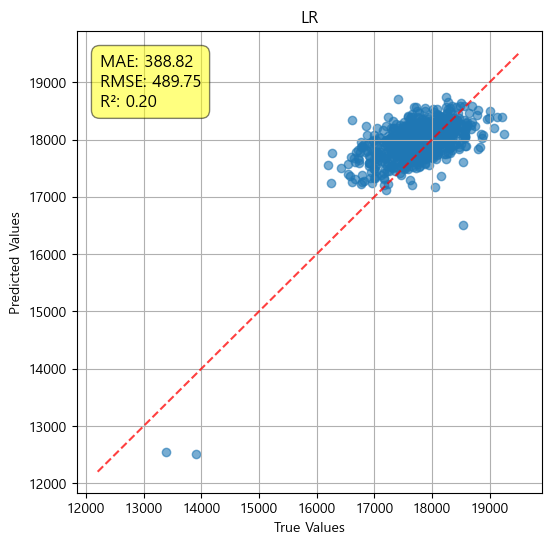

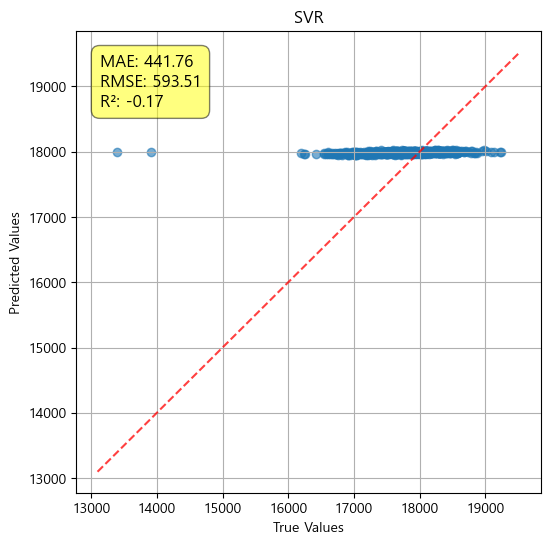

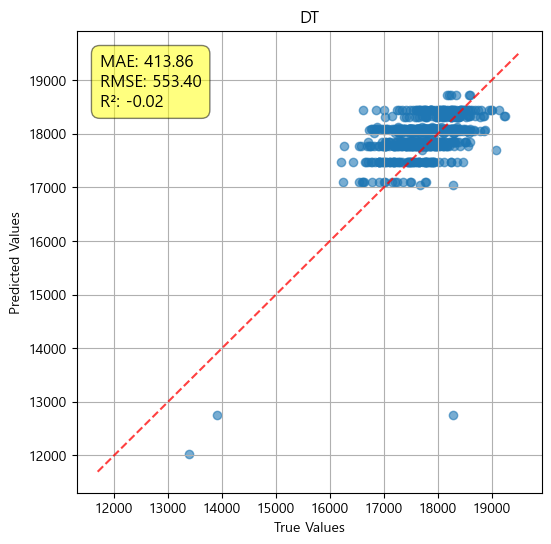

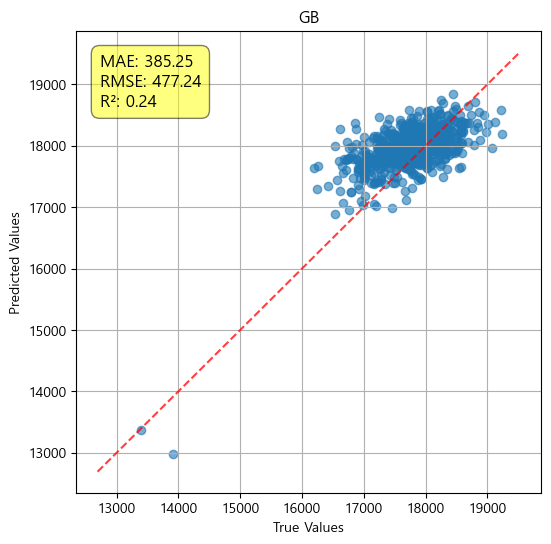

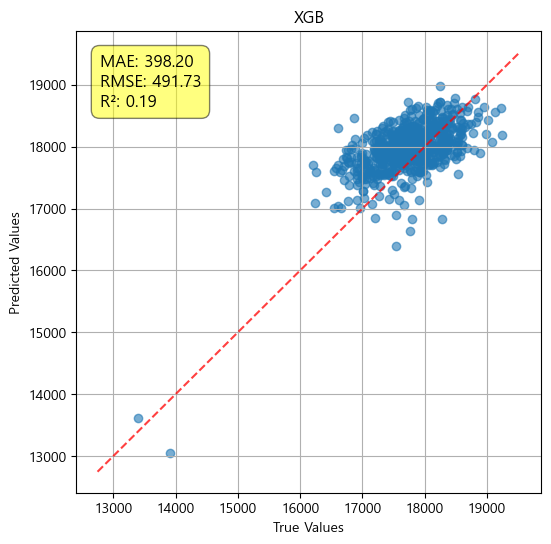

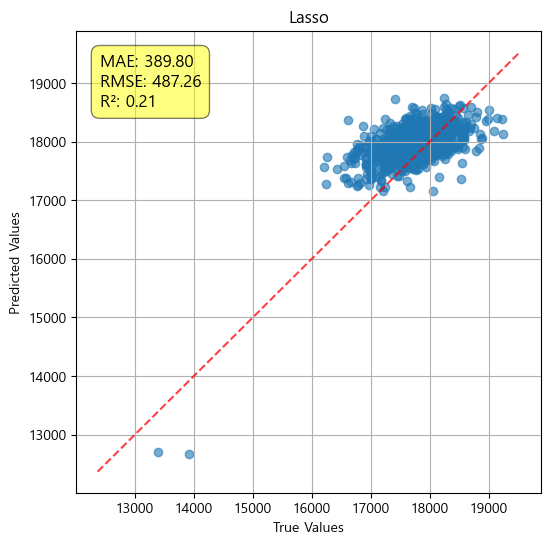

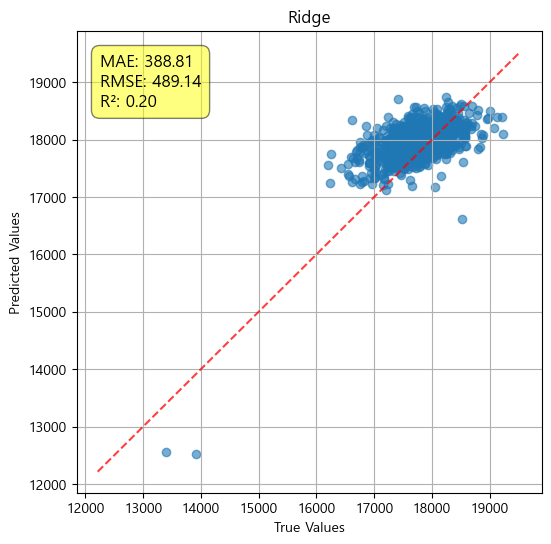

In [163]:
for model_name in models:
    # --- Your existing code ---
    models[model_name].fit(X_train, y_train)

    y_pred_train = models[model_name].predict(X_train)
    y_pred_test = models[model_name].predict(X_test)

    if model_name == 'LR':
        lr_y_test = y_test
        lr_y_pred_test = y_pred_test
        
    # predicts[model_name][0] = y_pred_train
    # predicts[model_name][1] = y_pred_test

    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)

    train_rmse = root_mean_squared_error(y_train, y_pred_train)
    test_rmse = root_mean_squared_error(y_test, y_pred_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f'{model_name} | train MAE: {train_mae:.2f} RMSE: {train_rmse:.2f} R2: {train_r2:.2f} | test MAE: {test_mae:.2f} RMSE: {test_rmse:.2f} R2: {test_r2:.2f}')

    # scatter_plot_mae(y_test, y_pred_test)
    scatter_plot_metric(y_test, y_pred_test, ['mae', 'rmse', 'r2'])
    
    plt.title(model_name)

Text(0.5, 1.0, 'LR')

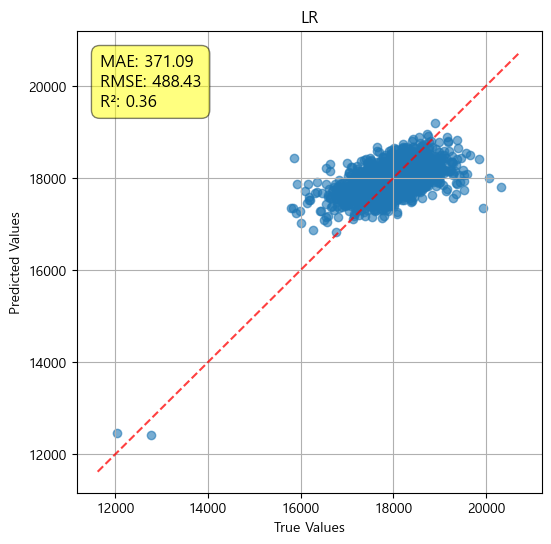

In [164]:
y_pred_train = models['LR'].predict(X_train)

scatter_plot_metric(y_train, y_pred_train, ['mae', 'rmse', 'r2'])
plt.title('LR')

LR train: 371.09 test: 388.82


Text(0.5, 1.0, 'LR')

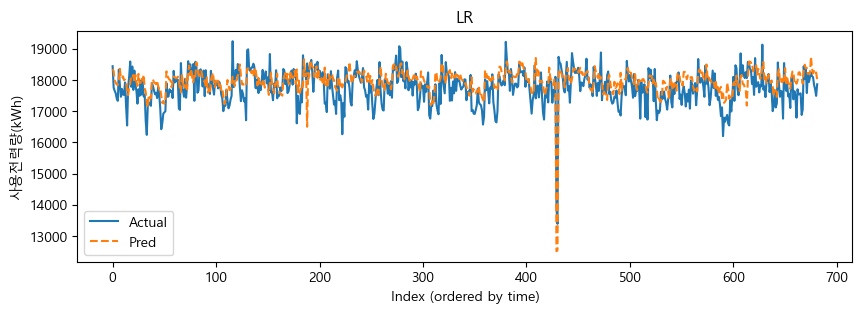

In [165]:
# --- Your existing code ---
y_pred_train = models['LR'].predict(X_train)
y_pred_test = models['LR'].predict(X_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'{'LR'} train: {train_mae:.2f} test: {test_mae:.2f}')

plt.figure(figsize=(10, 3))
# plt.plot(test_df[time_col], y_test, color='tab:blue', label='Actual')
plt.plot(range(len(test_df)), y_test, color='tab:blue', label='Actual')
# plt.plot(test_df[time_col], y_pred_test, color='tab:orange', linestyle='--', label='Pred')
plt.plot(range(len(test_df)), y_pred_test, color='tab:orange', linestyle='--', label='Pred')
plt.xlabel('Index (ordered by time)')
plt.ylabel('사용전력량(kWh)')
plt.legend()
plt.title('LR')


--- SHAP Summary: Linear Regression ---


C:\Users\User\AppData\Local\Temp\ipykernel_24260\742517770.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_lin, X_test, plot_type="bar")


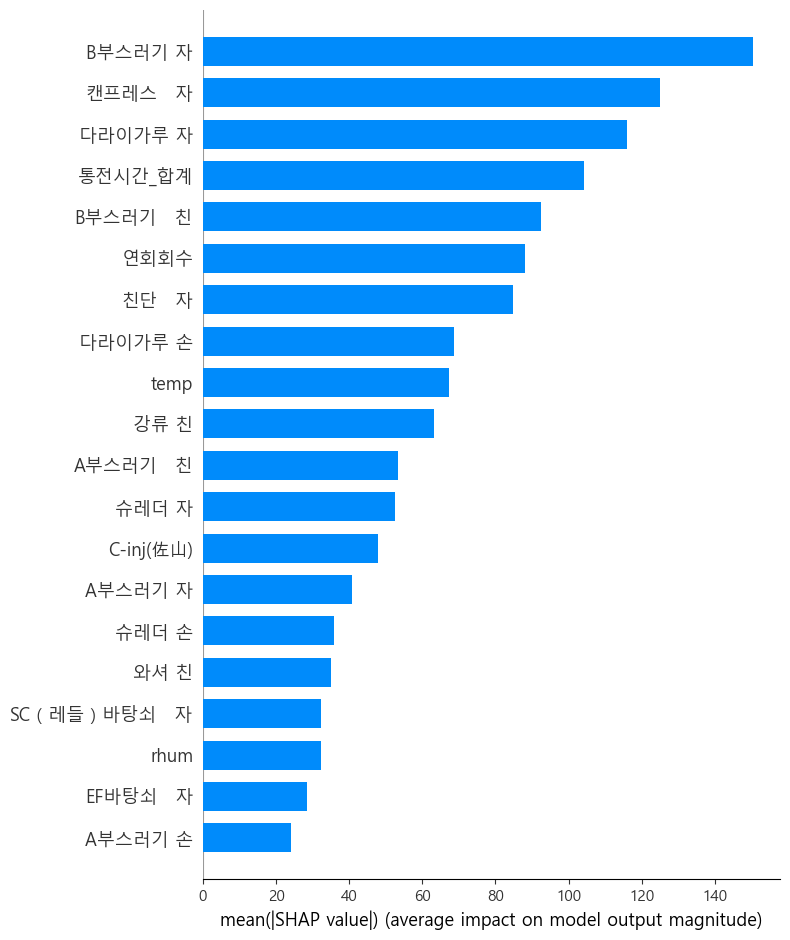

In [166]:
# SHAP for linear model
explainer_lin = shap.Explainer(models['LR'], X_test)
shap_values_lin = explainer_lin(X_test)

# Global importance plot
print("\n--- SHAP Summary: Linear Regression ---")
shap.summary_plot(shap_values_lin, X_test, plot_type="bar")

In [167]:
model = models['LR']

# Ensure the coefficients are 1-dimensional
coefficients = model.coef_.ravel() if len(model.coef_.shape) > 1 else model.coef_

# Get feature names
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'x{i}' for i in range(len(coefficients))]

# Create DataFrame of coefficients
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Print the intercept
print("Intercept:", model.intercept_)

# Show sorted coefficients by absolute magnitude
print(coeff_df.sort_values(by='Coefficient', key=abs, ascending=False))

Intercept: [17975.73251942]
                  Feature   Coefficient
9                 B부스러기 자  1.935156e+02
32                통전시간_합계  1.426082e+02
20                다라이가루 자  1.347180e+02
26                 캔프레스　자  1.300090e+02
8                 B부스러기　친  1.273900e+02
2                 A부스러기　친  1.148213e+02
21                다라이가루 손  1.144106e+02
35                   temp -1.098052e+02
33                   연회회수 -1.054274e+02
5                    친단　자  9.256805e+01
11                 선다라이 친  8.416018e+01
16                  슈레더 자  7.605261e+01
3                 A부스러기 자  7.591317e+01
17                  슈레더 손  7.337732e+01
22                   강류 친  6.638370e+01
28            SC（레들）바탕쇠　자  6.134063e+01
15                  슈레더 친  5.948958e+01
31              C-inj(佐山)  5.871135e+01
7                    와셔 친  5.780186e+01
19                 C프레스 자  5.154569e+01
13  시타마와리(자동차 부품으로 예상됨)　친  4.836370e+01
24                   주물　친  4.637319e+01
6                    친단　손  3.675726e+01
29          

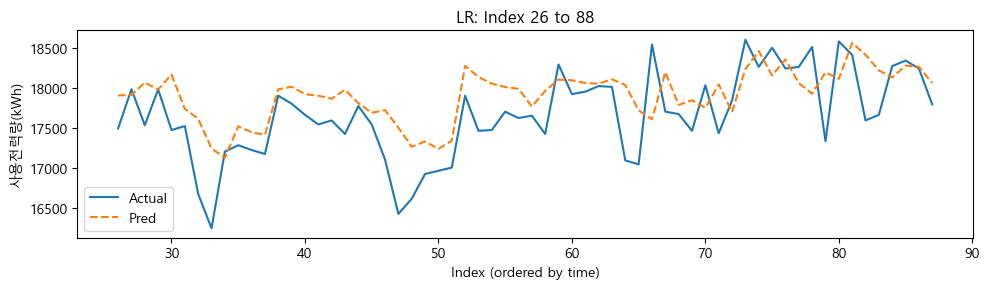

In [168]:
start_idx = 26
end_idx = 88

plt.figure(figsize=(10, 3))
plt.plot(range(start_idx, end_idx), y_test[start_idx:end_idx], color='tab:blue', label='Actual')
plt.plot(range(start_idx, end_idx), y_pred_test[start_idx:end_idx], color='tab:orange', linestyle='--', label='Pred')
plt.xlabel('Index (ordered by time)')
plt.ylabel('사용전력량(kWh)')
plt.legend()
plt.title('LR: Index {} to {}'.format(start_idx, end_idx))
plt.tight_layout()
plt.show()

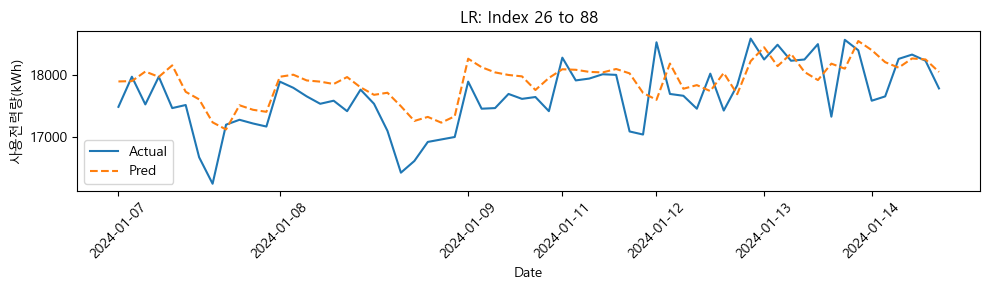

In [169]:
start_idx = 26
end_idx = 88

# Extract the date range from merged_df
date_series = merged_df['날짜'].iloc[start_idx:end_idx].reset_index(drop=True)

# Find the indices where the date changes
date_change_indices = [0] + [i for i in range(1, len(date_series)) if date_series[i] != date_series[i-1]]
date_change_labels = [date_series[i] for i in date_change_indices]

# Plot
plt.figure(figsize=(10, 3))
plt.plot(range(start_idx, end_idx), y_test[start_idx:end_idx], color='tab:blue', label='Actual')
plt.plot(range(start_idx, end_idx), y_pred_test[start_idx:end_idx], color='tab:orange', linestyle='--', label='Pred')
plt.xlabel('Date')
plt.ylabel('사용전력량(kWh)')
plt.legend()
plt.title('LR: Index {} to {}'.format(start_idx, end_idx))

# Adjust x-ticks to show only when the date changes
plt.xticks(ticks=[start_idx + i for i in date_change_indices], labels=date_change_labels, rotation=45)
plt.tight_layout()
plt.show()


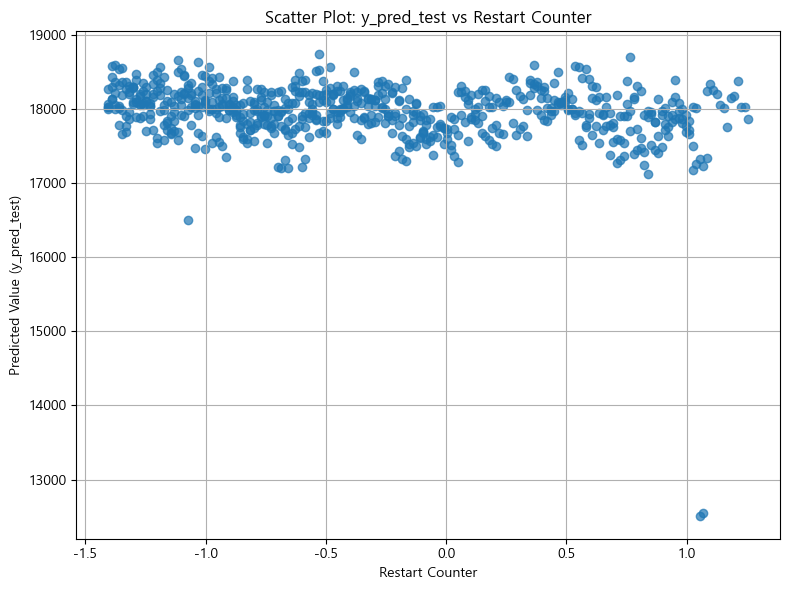

In [170]:
# Plot
restart_counter = X_test['restart_counter']

plt.figure(figsize=(8, 6))
plt.scatter(restart_counter, y_pred_test, alpha=0.7)
plt.xlabel("Restart Counter")
plt.ylabel("Predicted Value (y_pred_test)")
plt.title("Scatter Plot: y_pred_test vs Restart Counter")
plt.grid(True)
plt.tight_layout()
plt.show()

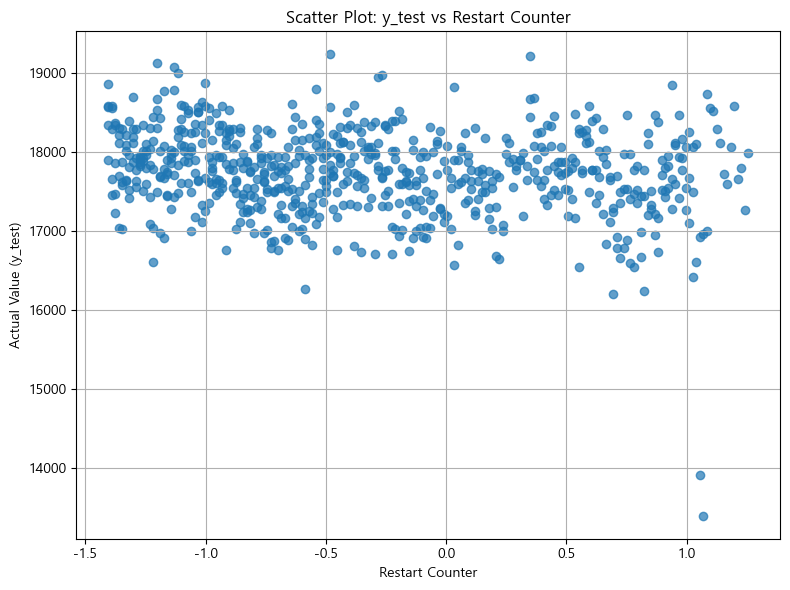

In [171]:
# Extract restart_counter from X_test
restart_counter = X_test['restart_counter']

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(restart_counter, y_test, alpha=0.7)
plt.xlabel("Restart Counter")
plt.ylabel("Actual Value (y_test)")
plt.title("Scatter Plot: y_test vs Restart Counter")
plt.grid(True)
plt.tight_layout()
plt.show()
